In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
from sklearn.model_selection import StratifiedKFold

In [2]:
import time

In [3]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [4]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [5]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [19]:
PATH_TO_DATA = './'

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'train.csv'), 
                                    index_col='match_id_hash')
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')

In [20]:
X = df_train_features.reset_index(drop=True)
y = df_train_targets['radiant_win'].astype(int)

In [21]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test.csv'), 
                                   index_col='match_id_hash')

X_test = df_test_features.reset_index(drop=True)

In [22]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.1,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary',
          'random_state' : 17
         }

Fold 0 started at Mon Nov 18 16:44:40 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.902529	valid_1's auc: 0.843658
[2000]	training's auc: 0.947044	valid_1's auc: 0.846743
Early stopping, best iteration is:
[2772]	training's auc: 0.969041	valid_1's auc: 0.847116
Fold 1 started at Mon Nov 18 16:46:05 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.90407	valid_1's auc: 0.83329
[2000]	training's auc: 0.947438	valid_1's auc: 0.836593
[3000]	training's auc: 0.973839	valid_1's auc: 0.837709
Early stopping, best iteration is:
[3115]	training's auc: 0.976091	valid_1's auc: 0.837825
Fold 2 started at Mon Nov 18 16:47:36 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.902261	valid_1's auc: 0.848131
[2000]	training's auc: 0.946645	valid_1's auc: 0.850476
Early stopping, best iteration is:
[2294]	training's auc: 0.955927	valid_1's auc: 0.850768
Fold 3 started at M

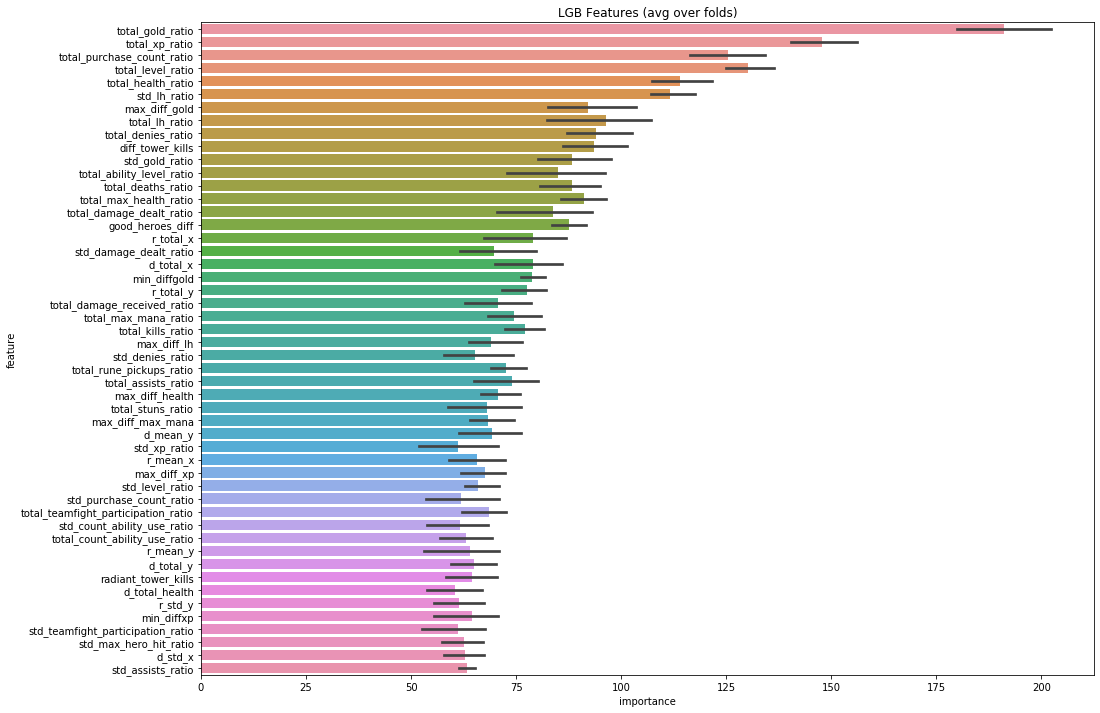

In [23]:
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [24]:
import datetime
submission_filename = 'submission_lgb{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

sub = pd.read_csv('./mlcourse-dota2-win-prediction/sample_submission.csv')
sub['radiant_win_prob'] = prediction_lgb
sub.to_csv(submission_filename, index=False)
print('Submission saved to {}'.format(submission_filename))
sub.head()

Submission saved to submission_lgb2019-11-18_19-12-13.csv


,match_id_hash,radiant_win_prob
0,30cc2d778dca82f2edb568ce9b585caa,0.282192
1,70e5ba30f367cea48793b9003fab9d38,0.992974
2,4d9ef74d3a2025d79e9423105fd73d41,0.966484
3,2bb79e0c1eaac1608e5a09c8e0c6a555,0.815420
4,bec17f099b01d67edc82dfb5ce735a43,0.248957
